In [25]:
# Uncomment only if you want to reprocess the raw data using initial_prep.py
# The script will re-create crashes.gz, comma separated gzipped file in ../data/processed

## %run ../src/preprocessing/initial_prep.py

In [26]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer #, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 

from sklearn import set_config
set_config(display ="diagram")

import matplotlib.pyplot as plt
%matplotlib inline




In [27]:

full_df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)

In [28]:
sample_df=full_df.sample(8000, random_state=100)
#sample_df=full_df.copy()

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size=0.25, stratify=y)


In [29]:
import joblib
import pickle

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

model_dic={}

joblib_file='XGB_models.pkl'
pkl_file_name='XGB_models.pikle'

with open (pkl_file_name, 'rb') as file:
    model_dic=pickle.load(file)

In [30]:

#model_dic['XGB_SAFETY_EQUIPMENT'] 

y_pred_test = model_dic['XGB_SAFETY_EQUIPMENT'].predict(X_test)
print(classification_report(y_test, y_pred_test))
print('accuracy', accuracy_score(y_test, y_pred_test))
print('precision', precision_score(y_test, y_pred_test, pos_label=0))
print('f1', f1_score(y_test, y_pred_test, pos_label=0))
print('recall', recall_score(y_test, y_pred_test, pos_label=0))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1317
           1       0.73      0.64      0.68       683

    accuracy                           0.80      2000
   macro avg       0.78      0.76      0.77      2000
weighted avg       0.79      0.80      0.79      2000

accuracy 0.798
precision 0.8258386866523911
f1 0.8513612950699043
recall 0.8785117691723614


In [31]:
#ordinal_columns = ['DRIVERS_LICENSE_CLASS']

#all_pred = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
#           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT','POSTED_SPEED_LIMIT','VEHICLE_DEFECT',
#            'ALIGNMENT', 'LIGHTING_CONDITION', 'WEATHER_CONDITION','SEX','DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 
#            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION', 'VEHICLE_YEAR', 'VEHICLE_AGE', 'TRAFFIC_CONTROL_DEVICE',
#     'SUN_GLARE']

numeric_columns = ['NUM_PASSENGERS']#,'SUN_GLARE']

nominal_columns = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT' ,  'TRAFFIC_CONTROL_DEVICE']

#models_dic={}
#models_dic['baseline_full_no_grid']=baseline_pipe
X_train=X_train[numeric_columns+nominal_columns]
X_test=X_test[numeric_columns+nominal_columns]

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0))
 #       ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


X_train_transformed = fu.fit_transform(X_train)
#X_train.info(verbose=True, show_counts=True)


In [33]:
columns=fu.transformer_list[1][1][2].get_feature_names_out()
columns=np.insert(columns, 0, 'Intercept')
#transformed_df=pd.DataFrame(X_train_transformed, columns=columns)
transformed_df=pd.DataFrame(X_train_transformed)
#transformed_df

#transformed_df.info(verbose=True, show_counts=True)


In [34]:

baseline_pipe = Pipeline([ ('fu', fu),
#                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('standardscale', StandardScaler()),
                          ('model',LogisticRegression(max_iter = 10000, solver = 'newton-cg', class_weight='balanced'))])
baseline_pipe.fit(X_train, y_train)

y_pred_test = baseline_pipe.predict(X_test)
y_pred_train = baseline_pipe.predict(X_train)


In [35]:


print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

y_hat_train_prob = baseline_pipe.decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = baseline_pipe.decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")


              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3951
           1       0.66      0.79      0.72      2049

    accuracy                           0.79      6000
   macro avg       0.77      0.79      0.78      6000
weighted avg       0.80      0.79      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1317
           1       0.66      0.76      0.70       683

    accuracy                           0.78      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.79      0.78      0.79      2000

Test:0.8342705091988869, Train:0.8527885953837387


In [36]:
#pipe_grid = {'model__solver': ['newton-cg','lbfgs']}
pipe_grid = {'model__solver': ['newton-cg']}
gs_pipe = GridSearchCV(estimator=baseline_pipe, param_grid=pipe_grid, cv=2, return_train_score=True)
gs_pipe

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant'))])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['DEVICE_CONDITION',
                                                                                                                            'FIRST_CR...
                                                                                                                            'TRAFFIC_CONTROL_DEVICE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value='NA',
                                                                                                       strategy='constant')),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('standardscale', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg']},
             return_train_score=True)

In [37]:
gs_pipe.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant'))])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['DEVICE_CONDITION',
                                                                                                                            'FIRST_CR...
                                                                                                                            'TRAFFIC_CONTROL_DEVICE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value='NA',
                                                                                                       strategy='constant')),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('standardscale', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg']},
             return_train_score=True)

In [38]:
gs_pipe.best_params_

{'model__solver': 'newton-cg'}

In [39]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [40]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

y_hat_train_prob = gs_pipe.decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = gs_pipe.decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3951
           1       0.66      0.79      0.72      2049

    accuracy                           0.79      6000
   macro avg       0.77      0.79      0.78      6000
weighted avg       0.80      0.79      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1317
           1       0.66      0.76      0.70       683

    accuracy                           0.78      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.79      0.78      0.79      2000

Test:0.8342705091988869, Train:0.8527885953837387


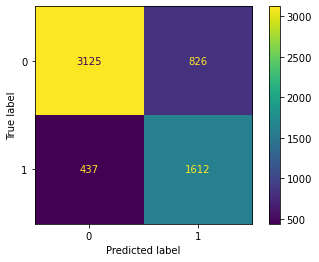

In [41]:

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

In [42]:


num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0))
 #       ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
#        ('imputer', SimpleImputer(strategy = 'constant', fill_value='NA'))
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])




bagged_tree_pipe = Pipeline([('fu', fu),
#                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
#                           ('label_encoder', LabelEncoder()),
#                         ('model',DecisionTreeClassifier(splitter='best', max_depth=5,
#                                                                  min_samples_split=2, min_samples_leaf=8))
                          ('model', RandomForestClassifier( n_estimators=150, min_samples_leaf=8, class_weight='balanced')),
#                          ('model', BaggingClassifier(DecisionTreeClassifier(splitter='best', max_depth=5,
#                                                                  min_samples_split=2, min_samples_leaf=8),n_estimators=150))
 
                              ])

bagged_tree_pipe

Pipeline(steps=[('fu',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                 ('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant'))])),
                                                ('cat_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['DEVICE_CONDITION',
                                                                                                     'FIRST_CRASH_TYPE',
                                                                                                     'FIRST_CONTACT_POI...
                                                                                                     'ROADWAY_SURFACE_COND',
                                                                                                     'VEHICLE_DEFECT',
                                                                                                     'DRIVERS_LICENSE_CLASS',
                                                                                                     'AGE_GROUP',
                                                                                                     'VEHICLE_AGE',
                                                                                                     'AIRBAG_DEPLOYED',
                                                                                                     'PHYSICAL_CONDITION',
                                                                                                     'MANEUVER',
                                                                                                     'DRIVER_VISION',
                                                                                                     'ALIGNMENT',
                                                                                                     'TRAFFIC_CONTROL_DEVICE'])),
                                                                 ('cat_encoder',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse=False))]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=8,
                                        n_estimators=150))])

In [43]:
bagged_tree_pipe.fit(X_train, y_train)
y_pred_test = bagged_tree_pipe.predict(X_test)
y_pred_train = bagged_tree_pipe.predict(X_train)

print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))



              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3951
           1       0.65      0.81      0.72      2049

    accuracy                           0.78      6000
   macro avg       0.77      0.79      0.77      6000
weighted avg       0.81      0.78      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1317
           1       0.64      0.76      0.69       683

    accuracy                           0.77      2000
   macro avg       0.75      0.77      0.75      2000
weighted avg       0.78      0.77      0.77      2000



In [46]:
pipe_grid = {'model__max_depth': [ 4, 5, 6,7,8 ], 
            'model__min_samples_leaf':[ 7, 8, 9, 10 ]}

#pipe_grid = {'model__criterion': ['gini', 'entropy']}



gs_pipe = GridSearchCV(estimator=bagged_tree_pipe, 
                       param_grid=pipe_grid, cv=10)

#gs_pipe.estimator[2][18]


In [47]:
#gs_pipe.fit(X_train, y_train)

In [48]:
plt.plot(train_fpr, train_tpr,  label='ROC curve {}'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)]);


NameError: name 'train_fpr' is not defined

In [50]:
y_pred_train=bagged_tree_pipe.predict(X_train)
y_pred_test=bagged_tree_pipe.predict(X_test)


In [51]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3951
           1       0.65      0.81      0.72      2049

    accuracy                           0.78      6000
   macro avg       0.77      0.79      0.77      6000
weighted avg       0.81      0.78      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1317
           1       0.64      0.76      0.69       683

    accuracy                           0.77      2000
   macro avg       0.75      0.77      0.75      2000
weighted avg       0.78      0.77      0.77      2000



In [52]:
y_hat_train_prob = gs_pipe.decision_function(X_train)
y_score = roc_auc_score(y_train, y_hat_train_prob)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train_prob)
y_score

max_depth=np.arange(0,32)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(18,36))
for i in max_depth:
    # Train the classifier using training data
    
    dt = Pipeline([('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('model',DecisionTreeClassifier(criterion='entropy', random_state=100,max_depth=i+1))
                              ])
#    dt = DecisionTreeClassifier(criterion='entropy', random_state=100,max_depth=i+1)
    dt.fit(X_train, y_train)
    # Make predictions using test set 
    y_pred = dt.predict(X_test)

    # Check the AUC of predictions
    fpr_test, tpr_test, thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
    roc_auc_test = auc(fpr_test, tpr_test)
    
    fpr_train, tpr_train, thresholds = roc_curve(y_train, dt.predict_proba(X_train)[:,1])
    roc_auc_train = auc(fpr_train, tpr_train)
    
    row = i//4
    col = i%4
    ax = axes[row, col]
    ax.plot(fpr_train, tpr_train, label=f'auc_train={roc_auc_train}')
    ax.plot(fpr_test, tpr_test, label=f'auc_test={roc_auc_test}')
    ax.set_title(f'max_depth={i+1}')
    ax.legend(loc='lower right')

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [166]:
y_pred_test = models_dic['baseline_full_no_grid'].predict(X_test)
y_pred_train = models_dic['baseline_full_no_grid'].predict(X_train)

print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))
y_hat_train_prob = models_dic['baseline_full_no_grid'].decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = models_dic['baseline_full_no_grid'].decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")


              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3951
           1       0.72      0.65      0.68      2049

    accuracy                           0.80      6000
   macro avg       0.78      0.76      0.77      6000
weighted avg       0.79      0.80      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1317
           1       0.72      0.63      0.67       683

    accuracy                           0.79      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.78      0.79      0.78      2000

Test:0.8432376035423692, Train:0.8445233638672074


In [ ]:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3951
           1       0.66      0.79      0.72      2049

    accuracy                           0.79      6000
   macro avg       0.77      0.79      0.78      6000
weighted avg       0.80      0.79      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1317
           1       0.66      0.76      0.70       683

    accuracy                           0.78      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.79      0.78      0.79      2000

Test:0.8342705091988869, Train:0.8527885953837387